In [14]:
import sys, os
import numpy as np
import joblib
import contextlib
from sklearn.model_selection import train_test_split
import pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from pyfrechet.metric_spaces import Sphere, Spheroid, angles_to_spheroid, sphere_to_spheroid, spheroid_to_sphere 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import geometric_slerp  # For geodesic interpolation
from matplotlib.lines import Line2D

In [15]:
# For to create the grid for the sphere
def create_S2_grid(grid_size: int=200) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
# Create a mesh grid for the unit sphere
    u = np.linspace(0, np.pi, grid_size)
    v = np.linspace(0, 2 * np.pi, grid_size)
    u, v = np.meshgrid(u, v)

    x_sphere = np.sin(u) * np.cos(v)
    y_sphere = np.sin(u) * np.sin(v)
    z_sphere = np.cos(u)
    return x_sphere, y_sphere, z_sphere

def plot_OOB_balls(M,
                   true_y: np.ndarray,
                   predictions: np.ndarray,
                   indices_to_plot: list[int],
                   Dalpha: float,
                   ax,
                   color='deepskyblue',
                   alpha=0.1,
                   N_points: int = 2000) -> None:
    """
    Plot OOB balls using canonical lattice sampling for the sphere.
    """
    # Sample points on the sphere using canonical lattice
    x_lattice, y_lattice, z_lattice = canonical_lattice(N_points)
    sphere_points = np.vstack((x_lattice, y_lattice, z_lattice)).T

    for index_to_plot in indices_to_plot:
        center = predictions[index_to_plot, :]
        # Compute distances from center to all lattice points
        dists = M.d(sphere_points, center)
        mask = dists <= Dalpha
        # Plot the points inside the ball
        ax.scatter3D(x_lattice[mask], y_lattice[mask], z_lattice[mask], color=color, alpha=alpha, s=2)

        # Plot the prediction and true value
        ax.scatter3D(center[0], center[1], center[2], marker='x', color='red', s=30, alpha=1)
        ax.scatter3D(true_y[index_to_plot, 0], true_y[index_to_plot, 1], true_y[index_to_plot, 2], marker='o', s=30, alpha=1, color='blue')
        ax.view_init(20, 90)

def area_pred_ball(M, radius, total_points):
    """
    Estimate the area of a prediction ball using the distance of M with given radius.
    The area is calculated by sampling points "uniformly" on the unit sphere and checking if they are within the radius.
    
    Parameters:
    - M: Metric space
    - radius: float, radius of the ball
    - total_points: int, number of points to sample

    Returns:
    - area: float, area of the ball
    """
    x, y, z = canonical_lattice(total_points)
    return 4*np.pi*np.sum((M.d(np.vstack((x,y,z)).T, np.array([np.sqrt(2)/2,np.sqrt(2)/2,0])) < radius))/total_points

def canonical_lattice(n: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a canonical lattice on the unit sphere.
    
    Parameters:
    - n: int, number of points to generate

    Returns:
    - x, y, z: coordinates of the points on the sphere
    """
    goldenRatio = (1 + 5**0.5)/2
    i = np.arange(0, n)
    theta = 2 * np.pi * i / goldenRatio
    phi = np.arccos(1 - 2*(i+0.5)/n)
    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)
    return x, y, z


np.random.seed(1000)
sign_level = np.array([0.01, 0.05, 0.1])

In [18]:
import numpy as np
import os

# Initialize a dictionary to store the loaded data
data_dict = {}

for i in range(12, 24):  # Cycles 12 to 23 (inclusive)
    filename = os.path.join(os.getcwd(), "results", f"new_results_cycle_{i}.npy")
    try:
        data = np.load(filename, allow_pickle=True)
        data_dict[i] = data  # Use cycle number as key
        print(f"Successfully loaded {filename}")
    except FileNotFoundError:
        print(f"File {filename} not found. Skipping...")

# Now you can access data by cycle number, e.g.:
cycle_15_data = data_dict[15].item()  # Raises KeyError if key doesn't exist

Successfully loaded /Users/Diego/Desktop/Codigo/Out-of-bag prediction balls for random forests in metric spaces/sunspots/results/new_results_cycle_12.npy
Successfully loaded /Users/Diego/Desktop/Codigo/Out-of-bag prediction balls for random forests in metric spaces/sunspots/results/new_results_cycle_13.npy
Successfully loaded /Users/Diego/Desktop/Codigo/Out-of-bag prediction balls for random forests in metric spaces/sunspots/results/new_results_cycle_14.npy
Successfully loaded /Users/Diego/Desktop/Codigo/Out-of-bag prediction balls for random forests in metric spaces/sunspots/results/new_results_cycle_15.npy
Successfully loaded /Users/Diego/Desktop/Codigo/Out-of-bag prediction balls for random forests in metric spaces/sunspots/results/new_results_cycle_16.npy
Successfully loaded /Users/Diego/Desktop/Codigo/Out-of-bag prediction balls for random forests in metric spaces/sunspots/results/new_results_cycle_17.npy
Successfully loaded /Users/Diego/Desktop/Codigo/Out-of-bag prediction balls 

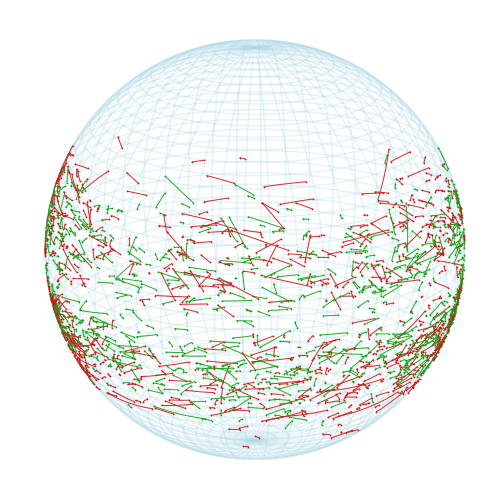

In [7]:
# TRUE BIRTHS AND DEATHS - TEST with geodesic paths
filename = f'sunspots_births_{23}_deaths.csv'
filepath = os.path.join(os.getcwd(), 'data', filename)
sample = pd.read_csv(filepath)
X = np.vstack([sample['births_X.1'], sample['births_X.2'], sample['births_X.3']]).T
y = np.vstack([sample['deaths_X.1'], sample['deaths_X.2'], sample['deaths_X.3']]).T
X_train_23, X_test_23, y_train_23, y_test_23 = train_test_split(X, y, test_size=0.25, random_state=1000)

filename = f'sunspots_births_{22}_deaths.csv'
filepath = os.path.join(os.getcwd(), 'data', filename)
sample = pd.read_csv(filepath)
X = np.vstack([sample['births_X.1'], sample['births_X.2'], sample['births_X.3']]).T
y = np.vstack([sample['deaths_X.1'], sample['deaths_X.2'], sample['deaths_X.3']]).T
X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(X, y, test_size=0.25, random_state=1000)

filename = f'sunspots_births_{21}_deaths.csv'
filepath = os.path.join(os.getcwd(), 'data', filename)
sample = pd.read_csv(filepath)
X = np.vstack([sample['births_X.1'], sample['births_X.2'], sample['births_X.3']]).T
y = np.vstack([sample['deaths_X.1'], sample['deaths_X.2'], sample['deaths_X.3']]).T
X_train_21, X_test_21, y_train_21, y_test_21 = train_test_split(X, y, test_size=0.25, random_state=1000)


X_test = np.concatenate((X_test_23, X_test_22), axis=0)
X_test = np.concatenate((X_test, X_test_21), axis=0)
y_test = np.concatenate((y_test_23, y_test_22), axis=0)
y_test = np.concatenate((y_test, y_test_21), axis=0)


fig = plt.figure()
fig.set_size_inches(7, 7)
ax = plt.axes(projection='3d', computed_zorder=False)

# Sphere mesh (just for visualization)
u = np.linspace(0, np.pi, 150)  # Higher resolution
v = np.linspace(0, 2 * np.pi, 150)
u, v = np.meshgrid(u, v)

x_sphere = np.sin(u) * np.cos(v)
y_sphere = np.sin(u) * np.sin(v)
z_sphere = np.cos(u)

# Plot the wireframe sphere
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.3, zorder=0)

# Define colors for clarity
positive_color = '#14A114'  # Green
negative_color = '#CA1919'  # Red

# Number of points to use for geodesic interpolation
n_points = 150

# Plot geodesics connecting birth to death and dots at both points
for birth, death in zip(X_test, y_test):
    # Only plot if birth y-coordinate is positive
    if birth[1] > 0:
        # Compute theta for direction
        theta_birth = np.arctan2(birth[1], birth[0])
        theta_death = np.arctan2(death[1], death[0])
        delta_theta = theta_death - theta_birth
        # Normalize to [-pi, pi]
        delta_theta = (delta_theta + np.pi) % (2 * np.pi) - np.pi

        # Line color: green if moving right, red if moving left
        line_color = positive_color if delta_theta > 0 else negative_color
        
        # Create geodesic path using SLERP
        # Define the interpolation parameter
        t_vals = np.linspace(0, 1, n_points)
        
        # Stack the points as start and end points
        
        # Perform the geodesic interpolation
        geodesic_points = geometric_slerp(birth, death, t_vals)
        
        # Draw the geodesic path
        ax.plot(geodesic_points[:, 0], 
                geodesic_points[:, 1], 
                geodesic_points[:, 2], 
                color=line_color, linewidth=1, alpha=0.9)
        
        # Add colored dots at both points
        ax.scatter(birth[0], birth[1], birth[2], color=line_color, linewidth=0, s=3, zorder=2)
        ax.scatter(death[0], death[1], death[2], color=line_color, linewidth=0, s=3, zorder=2)

# Create custom legend elements

legend_elements = [
    Line2D([0], [0], color=positive_color, linestyle='solid', markersize=10, label=r'$\Delta_\theta > 0$'),
    Line2D([0], [0], color=negative_color, linestyle='solid', markersize=10, label=r'$\Delta_\theta < 0$')
]

# Set zoom level by adjusting axis limits
ax.set_xlim(-0.3, .3)  # Zoom in on x-axis
ax.set_ylim(0, 1)      # Only show positive y (0 to 1 instead of -1 to 1)
ax.set_zlim(-.75, 1.2)  # Zoom in on z-axis

# Final plot settings - adjust view to better see the hemisphere with y > 0
ax.view_init(elev=20, azim=90)  # View from positive y-axis
Axes3D.set_aspect(ax, 'equal')

ax.grid(False)
ax.set_axis_off()
fig.tight_layout()

# For publication quality
#UNCOMMENT THE FOLLOWING LINE TO SAVE THE FIGURE
#plt.savefig('sunspot_trajectories.png', format='png', dpi = 75, bbox_inches='tight', transparent=True)
plt.show()

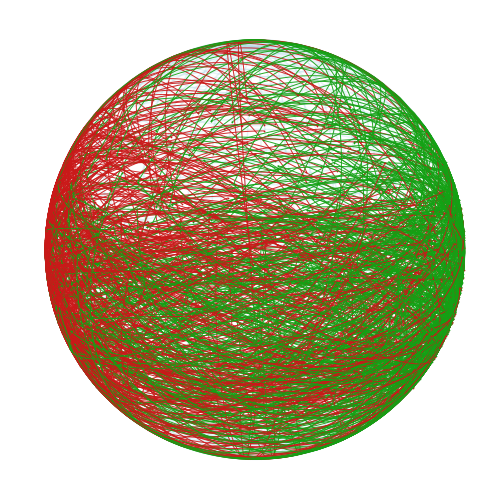

In [22]:
# TRUE BIRTHS AND DEATHS - TEST with geodesic paths

cycle_23_data = data_dict[23].item()  # Raises KeyError if key doesn't exist
filename = f'sunspots_births_{23}_deaths.csv'
filepath = os.path.join(os.getcwd(), 'data', filename)
sample = pd.read_csv(filepath)
X = np.vstack([sample['births_X.1'], sample['births_X.2'], sample['births_X.3']]).T
y = np.vstack([sample['deaths_X.1'], sample['deaths_X.2'], sample['deaths_X.3']]).T
X_train_23, X_test_23, y_train_23, y_test_23 = train_test_split(X, y, test_size=0.25, random_state=1000)
preds_23 = cycle_23_data['iso_preds']


filename = f'sunspots_births_{22}_deaths.csv'
filepath = os.path.join(os.getcwd(), 'data', filename)
sample = pd.read_csv(filepath)
X = np.vstack([sample['births_X.1'], sample['births_X.2'], sample['births_X.3']]).T
y = np.vstack([sample['deaths_X.1'], sample['deaths_X.2'], sample['deaths_X.3']]).T
X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(X, y, test_size=0.25, random_state=1000)
preds_22 = data_dict[22].item()['iso_preds']


filename = f'sunspots_births_{21}_deaths.csv'
filepath = os.path.join(os.getcwd(), 'data', filename)
sample = pd.read_csv(filepath)
X = np.vstack([sample['births_X.1'], sample['births_X.2'], sample['births_X.3']]).T
y = np.vstack([sample['deaths_X.1'], sample['deaths_X.2'], sample['deaths_X.3']]).T
X_train_21, X_test_21, y_train_21, y_test_21 = train_test_split(X, y, test_size=0.25, random_state=1000)
preds_21 = data_dict[21].item()['iso_preds']

X_test = np.concatenate((X_test_23, X_test_22), axis=0)
X_test = np.concatenate((X_test, X_test_21), axis=0)
y_test = np.concatenate((y_test_23, y_test_22), axis=0)
y_test = np.concatenate((y_test, y_test_21), axis=0)
preds = np.concatenate((preds_23, preds_22), axis=0)
preds = np.concatenate((preds, preds_21), axis=0)


fig = plt.figure()
fig.set_size_inches(7, 7)
ax = plt.axes(projection='3d', computed_zorder=False)

# Sphere mesh (just for visualization)
u = np.linspace(0, np.pi, 150)  # Higher resolution
v = np.linspace(0, 2 * np.pi, 150)
u, v = np.meshgrid(u, v)

x_sphere = np.sin(u) * np.cos(v)
y_sphere = np.sin(u) * np.sin(v)
z_sphere = np.cos(u)

# Plot the wireframe sphere
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.3, zorder=0)

# Define colors for clarity
positive_color = '#14A114'  # Green
negative_color = '#CA1919'  # Red

# Number of points to use for geodesic interpolation
n_points = 150

# Plot geodesics connecting birth to death and dots at both points
for birth, death in zip(X_test, preds):
    # Only plot if birth y-coordinate is positive
    if birth[1] > 0:
        # Compute theta for direction
        theta_birth = np.arctan2(birth[1], birth[0])
        theta_death = np.arctan2(death[1], death[0])
        delta_theta = theta_death - theta_birth
        # Normalize to [-pi, pi]
        delta_theta = (delta_theta + np.pi) % (2 * np.pi) - np.pi

        # Line color: green if moving right, red if moving left
        line_color = positive_color if delta_theta > 0 else negative_color
        
        # Create geodesic path using SLERP
        # Define the interpolation parameter
        t_vals = np.linspace(0, 1, n_points)
        
        # Stack the points as start and end points
        
        # Perform the geodesic interpolation
        geodesic_points = geometric_slerp(birth, death, t_vals)
        
        # Draw the geodesic path
        ax.plot(geodesic_points[:, 0], 
                geodesic_points[:, 1], 
                geodesic_points[:, 2], 
                color=line_color, linewidth=1, alpha=0.9)
        
        # Add colored dots at both points
        ax.scatter(birth[0], birth[1], birth[2], color=line_color, linewidth=0, s=3, zorder=2)
        ax.scatter(death[0], death[1], death[2], color=line_color, linewidth=0, s=3, zorder=2)

# Create custom legend elements
legend_elements = [
    Line2D([0], [0], color=positive_color, linestyle='solid', markersize=10, label=r'$\Delta_\theta > 0$'),
    Line2D([0], [0], color=negative_color, linestyle='solid', markersize=10, label=r'$\Delta_\theta < 0$')
]

# Set zoom level by adjusting axis limits
ax.set_xlim(-0.3, .3)  # Zoom in on x-axis
ax.set_ylim(0, 1)      # Only show positive y (0 to 1 instead of -1 to 1)
ax.set_zlim(-.75, 1.2)  # Zoom in on z-axis

# Final plot settings - adjust view to better see the hemisphere with y > 0
ax.view_init(elev=20, azim=90)  # View from positive y-axis
Axes3D.set_aspect(ax, 'equal')

ax.grid(False)
ax.set_axis_off()
fig.tight_layout()

# For publication quality
#UNCOMMENT THE FOLLOWING LINE TO SAVE THE FIGURE (this used to be uncommented)
#plt.savefig('predicted_sunspot_trajectories.png', format='png', dpi = 75, transparent = True, bbox_inches='tight')
plt.show()

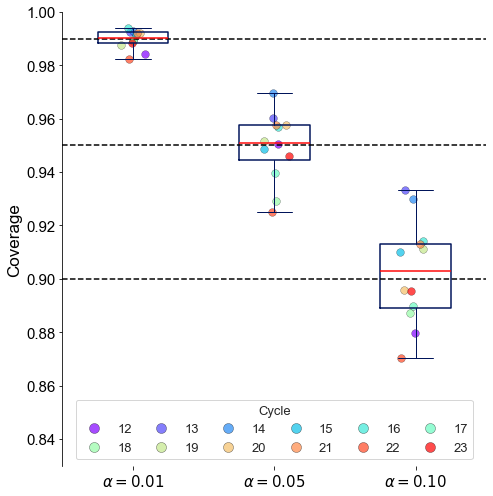

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import rainbow
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

reorder = lambda l, nc: sum((l[i::nc] for i in range(nc)), [])

np.random.seed(7)

# Custom styling for boxplots
boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1, linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

# Set up data and colors
alphas = [0.1, 0.05, 0.01]
positions = [0, 1, 2]
cycle_range = list(range(12, 24))
num_cycles = len(cycle_range)

# Create a color map with one unique color per cycle
cycle_colors = ListedColormap(rainbow(np.linspace(0, 1, num_cycles)))

# Organize data: map alpha -> list of (cycle, value) pairs
pb_ii_cov_by_alpha = {alpha: [] for alpha in alphas}
for i, cycle in enumerate(cycle_range):
    result = data_dict.get(cycle).item()
    if result is None:
        continue
    coverages = result['pb_ii_cov_iso_iso']
    for alpha, cov in zip(alphas, coverages):
        pb_ii_cov_by_alpha[alpha].append((cycle, cov))

# Prepare data for boxplot
boxplot_data = [[val for _, val in pb_ii_cov_by_alpha[alpha]] for alpha in alphas]

# Plot
fig, ax = plt.subplots(figsize=(7, 7), facecolor="white")
sns.set_style("whitegrid")

# Boxplot
ax.boxplot(boxplot_data, positions=positions, widths=0.5, notch=False,
           boxprops=boxprops, whiskerprops=whiskerprops,
           capprops=capprops, showfliers=False,
           medianprops=medianprops, showmeans=False)

# Jittered scatter with color per cycle
for j, alpha in enumerate(alphas):
    for (cycle_idx, val) in pb_ii_cov_by_alpha[alpha]:
        color_idx = cycle_range.index(cycle_idx)
        x_jitter = np.random.normal(loc=positions[j], scale=0.05)
        ax.scatter(x_jitter, val, alpha=0.7,
                   color=cycle_colors(color_idx),
                   s=60, edgecolor='k', linewidth=0.3,
                   label=f'{cycle_idx}' if j == 0 else None)  # label only once per cycle

# Axis styling
xtick_labels = [r'$\alpha = 0.01$', r'$\alpha = 0.05$', r'$\alpha = 0.10$']
ax.set_xticks(positions)
ax.set_xticklabels(xtick_labels, fontsize=17)
ax.set_ylabel('Coverage', fontsize=17)
ax.tick_params(labelsize=15)
ax.axhline(y=1-0.01, color='black', linestyle='dashed')
ax.axhline(y=1-0.05, color='black', linestyle='dashed')
ax.axhline(y=1-0.1, color='black', linestyle='dashed')
ax.set_ylim(0.83, 1)
ax.grid(False)
sns.despine(bottom=True)

# Custom legend for cycles
legend_handles = [
    mlines.Line2D([], [], color=cycle_colors(i), marker='o', markeredgecolor='k', markeredgewidth=0.4, linestyle='none',
                  markersize=10, alpha = 0.7, label=f'{cycle_range[i]}')
    for i in range(num_cycles)
]

# Reorder legend handles for horizontal layout with 3 columns
ax.legend(handles=reorder(legend_handles, 6), title="Cycle", fontsize=13, title_fontsize=13,
          ncol=6, columnspacing = 1.25, loc='lower center')

fig.tight_layout()

#UNCOMMENT THE FOLLOWING LINE TO SAVE THE FIGURE (this used to be uncommented)
plt.savefig("sunspots_ii_cov.png", bbox_inches='tight', format='png', dpi = 75, transparent=True)
plt.show()

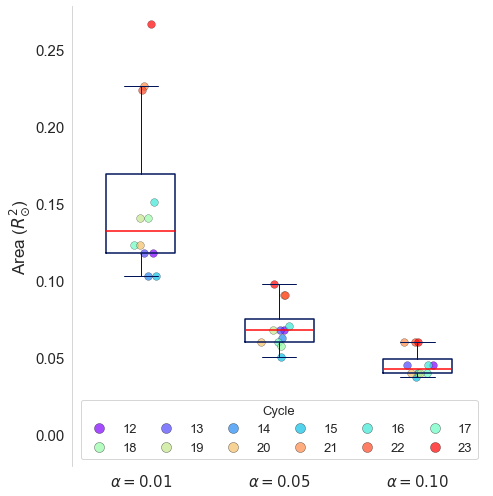

In [ ]:
# Reuse style settings and helpers
reorder = lambda l, nc: sum((l[i::nc] for i in range(nc)), [])
np.random.seed(0)
# Prepare data
alphas = [0.1, 0.05, 0.01]
positions = [0, 1, 2]
cycle_range = list(range(12, 24))
num_cycles = len(cycle_range)

# Color map for cycles
cycle_colors = ListedColormap(rainbow(np.linspace(0, 1, num_cycles)))

# Organize area data by alpha
area_by_alpha = {alpha: [] for alpha in alphas}
for cycle in cycle_range:
    result = data_dict.get(cycle).item()
    if result is None:
        continue
    areas = result['area_iso_iso']
    for alpha, area in zip(alphas, areas):
        area_by_alpha[alpha].append((cycle, area))

# Format data for boxplot
boxplot_data = [[val for _, val in area_by_alpha[alpha]] for alpha in alphas]

# Plot
fig, ax = plt.subplots(figsize=(7, 7), facecolor="white")
sns.set_style("whitegrid")

# Boxplot
ax.boxplot(boxplot_data, positions=positions, widths=0.5, notch=False,
           boxprops=boxprops, whiskerprops=whiskerprops,
           capprops=capprops, showfliers=False,
           medianprops=medianprops, showmeans=False)

# Jittered scatter with color per cycle
for j, alpha in enumerate(alphas):
    for (cycle_idx, val) in area_by_alpha[alpha]:
        color_idx = cycle_range.index(cycle_idx)
        x_jitter = np.random.normal(loc=positions[j], scale=0.05)
        ax.scatter(x_jitter, val, alpha=0.7,
                   color=cycle_colors(color_idx),
                   s=60, edgecolor='k', linewidth=0.3,
                   label=f'{cycle_idx}' if j == 0 else None)

# Axis styling
xtick_labels = [r'$\alpha = 0.01$', r'$\alpha = 0.05$', r'$\alpha = 0.10$']
ax.set_xticks(positions)
ax.set_xticklabels(xtick_labels, fontsize=17)
ax.set_ylabel(r'Area ($R^2_{\odot}$)', fontsize=17)
ax.tick_params(labelsize=15)
ax.set_ylim(bottom=-0.02)  # optional: adjust based on your data
ax.grid(False)
sns.despine(bottom=True)

# Custom legend
legend_handles = [
    mlines.Line2D([], [], color=cycle_colors(i), marker='o', linestyle='none', markeredgecolor='k', markeredgewidth=0.4, 
                  markersize=10, alpha=0.7, label=f'{cycle_range[i]}')
    for i in range(num_cycles)
]
ax.legend(handles=reorder(legend_handles, 6), title="Cycle", fontsize=13, title_fontsize=13,
          ncol=6, columnspacing=1.25, loc='lower center')

fig.tight_layout()

#UNCOMMENT THE FOLLOWING LINE TO SAVE THE FIGURE (this used to be uncommented)
plt.savefig("sunspots_area.png", bbox_inches='tight', format='png', dpi = 75, transparent=True)
plt.show()

In [ ]:
def plot_OOB_balls(M,
                   true_y: np.ndarray,
                   predictions: np.ndarray,
                   indices_to_plot: list[int],
                   Dalpha: float,
                   ax,
                   color='deepskyblue',
                   alpha=0.1,
                   N_points: int = 2000) -> None:
    """
    Plot OOB balls using canonical lattice sampling for the sphere.
    """
    # Sample points on the sphere using canonical lattice
    x_lattice, y_lattice, z_lattice = canonical_lattice(N_points)
    sphere_points = np.vstack((x_lattice, y_lattice, z_lattice)).T

    for index_to_plot in indices_to_plot:
        center = predictions[index_to_plot, :]
        # Compute distances from center to all lattice points
        dists = M.d(sphere_points, center)
        mask = dists <= Dalpha
        # Plot the points inside the ball
        ax.scatter3D(x_lattice[mask], y_lattice[mask], z_lattice[mask], color=color, alpha=alpha, s=2)

        # Plot the prediction and true value
        ax.scatter3D(center[0], center[1], center[2], marker='x', color='red', s=30, alpha=1)
        ax.scatter3D(true_y[index_to_plot, 0], true_y[index_to_plot, 1], true_y[index_to_plot, 2], marker='o', s=30, alpha=1, color='#DFA700')
        ax.view_init(20, 90)

In [ ]:
def create_spheroid_points(N_points: int, a: float=1.0, c: float=1.0) -> np.ndarray:
    """
    This is the grid we use to plot the prediction balls
    """
    # Create grid in angle space
    u = np.linspace(0, np.pi, int(np.sqrt(N_points)))
    v = np.linspace(0, 2 * np.pi, 2*int(np.sqrt(N_points)))
    u, v = np.meshgrid(u, v)
    angles = np.stack([u.flatten(), v.flatten()], axis=-1)
    
    # Convert angles to spheroid points
    return angles_to_spheroid(angles, a=a, c=c)

# Modified plot_OOB_balls function for custom points
def sphere_custom_centers_plot_OOB_balls(M, points, true_y, Dalpha, ax, a=1.0, c=1.0, 
                   colors=['green', 'blue'], alpha=0.1, N_points=2000):
    """
    Plot OOB balls using direct spheroid sampling.
    """
    # Sample points directly on spheroid
    spheroid_points = create_spheroid_points(N_points, a=a, c=c)
    for i, center in enumerate(points):
        # Compute distances from center to all points
        dists = M.d(spheroid_points, center)
        mask = dists <= Dalpha
        mask = mask.squeeze()
        
        sphere_points = spheroid_to_sphere(spheroid_points[mask], a, c, R=1)
        
        # Plot the points inside the ball (in sphere coordinates)
        ax.scatter3D(sphere_points[:,0], sphere_points[:,1], sphere_points[:,2],
                    color='blue', alpha=alpha, s=2)
        
        # Map prediction and true value back to sphere and plot
        center_sphere = spheroid_to_sphere(center.reshape(1,-1), a, c, R=1)
        ax.scatter3D(center_sphere[0,0], center_sphere[0,1], center_sphere[0,2], 
                    marker='x', color='red', s=30, alpha=1)
        ax.scatter3D(true_y[i, 0], true_y[i, 1], true_y[i, 2], marker='o', s=30, alpha=1, color='#DFA700')
        

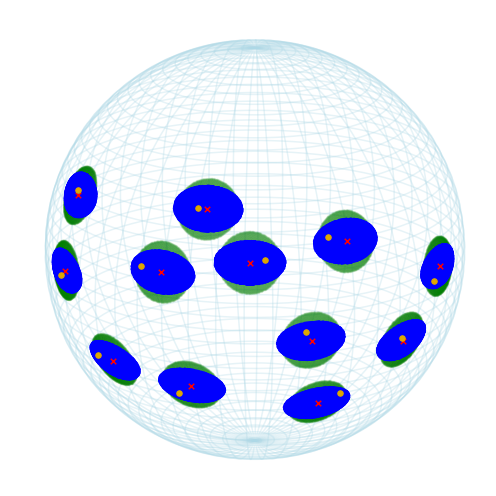

In [ ]:
# Load the data for both sphere and spheroid
y_test_sphere = y_test_23
preds_sphere = data_dict[23].item()['iso_preds']

# Set up the figure
fig = plt.figure()
fig.set_size_inches(7, 7)
ax = plt.axes(projection='3d', computed_zorder=False)

# Create sphere wireframe
x_sphere, y_sphere, z_sphere = create_S2_grid(grid_size=100)
ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color='lightblue', alpha=0.3, zorder=0)

# Define indices and filter them
indices = [7, 28, 29, 32, 36, 37, 49, 50, 94, 96, 255, 256, 257, 266]
new_indices = [idx for idx in indices if preds_sphere[idx][1] >= 0]

# Create metric spaces
M_sphere = Sphere(2)
M_spheroid = Spheroid(a=0.6, c=1.0)

# First plot the sphere balls (in green)
plot_OOB_balls(M=M_sphere, 
               predictions=preds_sphere, 
               true_y=y_test_sphere, 
               indices_to_plot=new_indices, 
               Dalpha=data_dict[23].item()['oob_quantile_iso_iso'][2],
               ax=ax, 
               color='green', 
               alpha=0.1, 
               N_points=1000000)

# Then plot the spheroid balls mapped back to sphere (in blue)
sphere_custom_centers_plot_OOB_balls(M=M_spheroid,
                                   points=sphere_to_spheroid(preds_sphere[new_indices], a=0.6, c=1.0),
                                   true_y = y_test_sphere[new_indices],
                                   Dalpha=data_spheroid_23['oob_quantile_spheroid'][2],
                                   ax=ax,
                                   a=0.6,
                                   c=1.0,
                                   colors=['blue'],
                                   alpha=1,
                                   N_points=1000000)
0
# Set the view and limits
ax.view_init(elev=20, azim=90)
ax.set_xlim(-0.3, .3)
ax.set_ylim(0, 1)
ax.set_zlim(-.75, 1.2)
Axes3D.set_aspect(ax, 'equal')
ax.grid(False)
ax.set_axis_off()

# Add legend
# legend_elements = [
#     Line2D([0], [0], marker='x', color='red', linestyle='None', markersize=10, label='Predicted location'),
#     Line2D([0], [0], marker='o', color='blue', linestyle='None', markersize=10, label='True location'),
#     mpatches.Rectangle((0, 0), 1, 1, facecolor='green', edgecolor='green', alpha=0.3, label='Sphere 90% prediction ball'),
#     mpatches.Rectangle((0, 0), 1, 1, facecolor='blue', edgecolor='blue', alpha=0.3, label='Spheroid 90% prediction ball')
# ]
# ax.legend(handles=legend_elements, loc='upper right', fontsize=13)

# fig.savefig('sunspots_spheroid_balls.png', format='png', dpi=75, bbox_inches='tight')
fig.tight_layout()
plt.show()